In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt

In [2]:
# Define the dataset class
class MovieReviewDataset(Dataset):
    def __init__(self, data, labels, tokenizer, vocab):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data[index]
        label = self.labels[index]
        tokens = self.tokenizer(text)
        indices = [self.vocab[token] for token in tokens]
        return indices, label

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2, dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

        # Initialize LSTM and fully connected layers with Xavier initialization
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
        nn.init.xavier_normal_(self.fc.weight)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = hidden[-1]  # Use the last hidden state from the last layer
        output = self.fc(output)
        # output = self.sigmoid(output)
        return output

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

# Set hyperparameters
embedding_dim = 50
hidden_dim = 100
num_layers = 2
output_dim = 1
batch_size = 64
num_epochs = 1
learning_rate = 0.001

Device:  cuda


In [5]:
# Load and preprocess the dataset
def load_dataset(root_dir):
    data = []
    labels = []
    for label in ['pos', 'neg']:
        label_dir = os.path.join(root_dir, label)
        for filename in os.listdir(label_dir):
            file_path = os.path.join(label_dir, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                data.append(text)
                rating = int(filename.split('_')[-1].split('.')[0])
                normalized_rating = (rating - 1) / 9.0
                labels.append(normalized_rating)
    return data, labels

train_dir = 'aclImdb/train'
test_dir = 'aclImdb/test'
tokenizer = get_tokenizer('basic_english')

train_data, train_labels = load_dataset(train_dir)
test_data, test_labels = load_dataset(test_dir)

In [6]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = [len(text) for text in texts]
    padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True)
    return padded_texts, torch.tensor(lengths), torch.tensor(labels)
    
def yield_tokens(data):
    for text in data:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

train_dataset = MovieReviewDataset(train_data, train_labels, tokenizer, vocab)
test_dataset = MovieReviewDataset(test_data, test_labels, tokenizer, vocab)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [8]:
# Initialize the model
model = LSTMModel(len(vocab), embedding_dim, hidden_dim, output_dim, num_layers).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Load saved state dictionaries if they exist
checkpoint_path = 'model_checkpoint2.pt'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    print(f"Loaded checkpoint from epoch {start_epoch}")
else:
    start_epoch = 0
    train_losses = []
    test_losses = []
    
# Training loop
for epoch in range(start_epoch, num_epochs + start_epoch):
    model.train()
    train_loss = 0.0

    for inputs, lengths, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).float()
        lengths = lengths.cpu()  # Move lengths to CPU

        optimizer.zero_grad()
        outputs = model(inputs, lengths).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for inputs, lengths, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            lengths = lengths.cpu()  # Move lengths to CPU
            outputs = model(inputs, lengths).squeeze()
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_dataset)
    test_losses.append(test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs + start_epoch}], Train Loss: {train_loss:.10f}, Test Loss: {test_loss:.10f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }, checkpoint_path)

Loaded checkpoint from epoch 284
Epoch [285/285], Train Loss: 0.1408430256, Test Loss: 0.1427303507


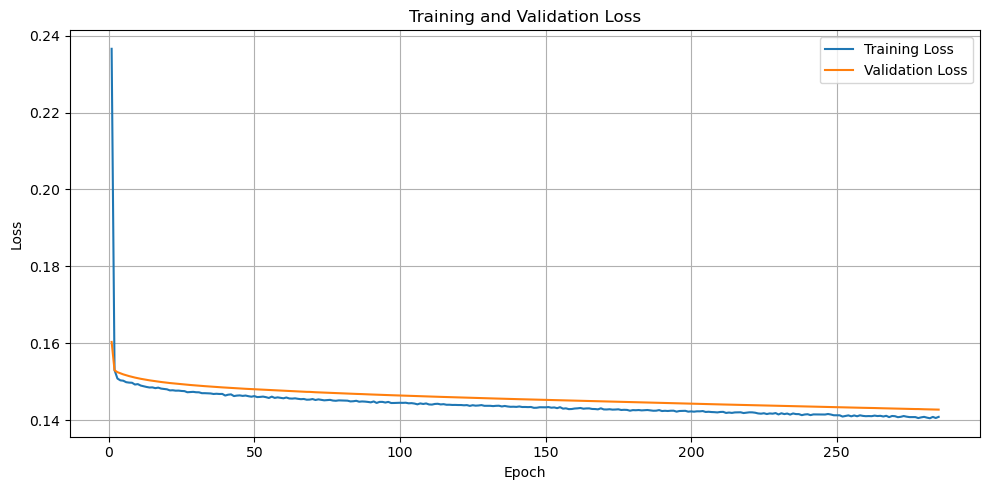

In [9]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()